# Exploratory Analysis Notebook

## 1. Introduction

## 2. Environment Setup and Library Imports

In [1]:
# Libraries
import warnings
import os
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from sklearn.impute import KNNImputer
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import r2_score
import folium
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer
from sklearn.preprocessing import MinMaxScaler

# Set-up environment
pd.options.display.float_format = '{:.2f}'.format
pd.set_option('display.max_colwidth', None)
sns.set_theme(style="whitegrid", context="paper")
os.chdir('/Users/nataschajademinnitt/Documents/5. Data Analysis/segmenting_customers/')
print("Current directory:", os.getcwd())
warnings.filterwarnings("ignore")

Current directory: /Users/nataschajademinnitt/Documents/5. Data Analysis/segmenting_customers


## 3. Load Data

In [3]:
# Load the data
df_features = pd.read_csv("./data/processed/customer_features.csv")
df_customers = pd.read_csv("./data/processed/customers.csv")

# Merging customers onto orders
df_merged = pd.merge(df_features, df_customers[['customer_id', 'customer_unique_id']], on='customer_id', how='left')
df_merged.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96478 entries, 0 to 96477
Data columns (total 17 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   order_id                  96478 non-null  object 
 1   customer_id               96478 non-null  object 
 2   order_purchase_timestamp  96478 non-null  object 
 3   customer_zip_code_prefix  96478 non-null  int64  
 4   customer_state            96478 non-null  object 
 5   geolocation_lat           96214 non-null  float64
 6   geolocation_lng           96214 non-null  float64
 7   recency_days              96478 non-null  float64
 8   s_delivery_diff           96470 non-null  float64
 9   f_products                96478 non-null  int64  
 10  m_price                   96478 non-null  float64
 11  m_freight                 96478 non-null  float64
 12  s_review_score            95832 non-null  float64
 13  s_review_count            95832 non-null  float64
 14  m_cred

### 3.1 Product Category Popularity Scoring

This feature allocates a score to the 73 product categories based on their popularity, which is determined by the recency of their purchase (days since last purchase) and the frequency (count of product_id in order_items). The time scope is 1 year since the most recent purchase date.

In [5]:
df_product_scores = pd.read_csv("./data/processed/product_score_table.csv")

# Normalize columns
cols = ['recency', 'frequency']
scaler = MinMaxScaler()
df_product_scores[cols] = scaler.fit_transform(df_product_scores[cols])

# Compute a combined “product score”
a = df_product_scores['recency']
b = df_product_scores['frequency']

df_product_scores['product_score'] = (1 / (1 + a)) + b  # reverse score recency

df_product_scores.sort_values('product_score', ascending=False)

,product_category_name,frequency,recency,product_score
14,cama_mesa_banho,1.00,0.04,1.96
12,beleza_saude,0.93,0.03,1.90
33,esporte_lazer,0.76,0.04,1.72
45,informatica_acessorios,0.74,0.03,1.70
55,moveis_decoracao,0.71,0.04,1.67
...,...,...,...,...
53,moveis_colchao_e_estofado,0.00,0.44,0.70
69,tablets_impressao_imagem,0.00,0.62,0.62
38,fashion_roupa_infanto_juvenil,0.00,0.66,0.60
18,cds_dvds_musicais,0.00,0.98,0.51


In [7]:
# Merge with df_products_raw
df_products_raw = pd.read_csv("./data/processed/product_order_table.csv")

df_product_raw_scored = df_products_raw.merge(
    df_product_scores[['product_category_name', 'product_score']],
    on='product_category_name',
    how='left'
)

# Group by most common category
order_product_code = (
    df_product_raw_scored
      .groupby('order_id')['product_score']
      .agg(lambda x: x.mode()[0] if not x.mode().empty else np.nan)
      .reset_index()
)

# Merge onto df_merged
df = df_merged.merge(
    order_product_code,
    on='order_id',
    how='left'
)

When allocating product category scores to order_ids in the merged_df, there are instances where an order_id is associated with more than one category. The most frequent category in an order is selected, in a few instances, there is no single most frequent category, in which case the most popular category is selected as the default.

In [9]:
# Check instances of multiple categories for an order_id
order_score_counts = (
    df_product_raw_scored
      .groupby('order_id')['product_score']
      .nunique()
      .reset_index(name='n_unique_scores')
)

multi_score_orders = order_score_counts[order_score_counts['n_unique_scores'] > 1]

n_multi = multi_score_orders.shape[0]
total_orders = order_score_counts.shape[0]

print(f"{n_multi} orders out of {total_orders} "
      f"({n_multi/total_orders:.1%}) have more than one product_score.")

786 orders out of 98666 (0.8%) have more than one product_score.


## 4. Data Cleaning and Filtering

**Filter for a 1 year timeframe**

By filtering for 1 year we account for seasonal variation.

In [11]:
# Removing the time string
df['order_purchase_timestamp'] = pd.to_datetime(df['order_purchase_timestamp'])

orders_per_year = (df.groupby(df['order_purchase_timestamp'].dt.year).size().rename('order_count'))
print(orders_per_year)

# One year before the latest purchase
cutoff = df['order_purchase_timestamp'].max() - pd.DateOffset(years=1)
df = df[df['order_purchase_timestamp'] >= cutoff]

print(f"Filtering for orders on or after {cutoff.date()}")
print(df['order_purchase_timestamp'].min(), "to", df['order_purchase_timestamp'].max())

order_purchase_timestamp
2016      267
2017    43428
2018    52783
Name: order_count, dtype: int64
Filtering for orders on or after 2017-08-29
2017-08-29 15:02:12 to 2018-08-29 15:00:37


**Replace missing values**
1. Replace geolocation_lat and geolocation_lng outside of Brazil with nan
2. Fill geolocation_lat and geolocation_lng nan with KNN imputer zipcodes

In [13]:
# Replace values outside Brazil's approximate bounds with NaN
df.loc[(df['geolocation_lat'] < -33.75116944) | (df['geolocation_lat'] > 5.27438888), 'geolocation_lat'] = np.nan
df.loc[(df['geolocation_lng'] < -73.98283055) | (df['geolocation_lng'] > -34.79314722), 'geolocation_lng'] = np.nan

# Using KNeighborsRegressor to predict longitude and latitude
df_impute = df[df[['geolocation_lat', 'geolocation_lng']].notna().all(axis=1)].copy()

X = df_impute[['customer_zip_code_prefix']]
y = df_impute[['geolocation_lat', 'geolocation_lng']]

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=42)

knn_reg = KNeighborsRegressor(n_neighbors=5)
knn_reg.fit(X_train, y_train)

y_pred = knn_reg.predict(X_val)

r2 = knn_reg.score(X_val, y_val)
print("R²:", r2)

# Fill numeric values using the KNN imputer
features = ['customer_zip_code_prefix', 'geolocation_lat', 'geolocation_lng']

imputer = KNNImputer(n_neighbors=5)
df[features] = imputer.fit_transform(df[features])

missing_values_after = df[features].isna().sum()
print("Missing values per column after final KNN imputation:")
print(missing_values_after)

R²: 0.9988499693326212
Missing values per column after final KNN imputation:
customer_zip_code_prefix    0
geolocation_lat             0
geolocation_lng             0
dtype: int64


**Groupby customer_unique_id**

In [15]:
customer_features = (df.groupby('customer_unique_id').agg({
        'order_purchase_timestamp': 'max',    # last purchase
        'order_id':                 'count',  # number of orders
        'f_products':               'sum',    # total items bought
        'm_price':                  'sum',    # total spend
        'm_freight':                'sum',    # total freight
        'm_credit':                 'max',    # ever used credit
        'm_total_installments':     'mean',   # avg installment count
        's_review_score':           'mean',   # avg review
        's_delivery_diff':          'mean',   # avg delivery lateness
        'product_score':            lambda x: x.mode()[0] if not x.mode().empty else np.nan,
        'customer_state':           'first',  # static per customer
        'geolocation_lat':          'first',
        'geolocation_lng':          'first',
    }).reset_index()
)

## 5. Feature Engineering

### 5.1. Recency

In [37]:
# recency : days since the last purchase
reference_date = pd.to_datetime(customer_features['order_purchase_timestamp']).max()

customer_features['recency'] = (reference_date - pd.to_datetime(customer_features['order_purchase_timestamp'])).dt.days

In [43]:
# recent_flag : less than 30, 30 to 90, more than 90
customer_features['recent_flag'] = pd.cut(customer_features['recency'], bins=[0, 30, 90, 365], labels=[0, 1, 2], include_lowest=True)
customer_features['recent_flag'] = customer_features['recent_flag'].cat.codes
customer_features['recent_flag'].value_counts()

recent_flag
2    54030
1    11588
0     7002
Name: count, dtype: int64

### 5.2 Frequency

In [45]:
# f_returning : Binary variable for returning customers
customer_features.rename(columns={'order_id': 'f_orders'}, inplace=True)
customer_features['f_returning'] = np.where(customer_features['f_orders'] == 1, 0, 1)
customer_features['f_returning'].value_counts()

f_returning
0    70810
1     1810
Name: count, dtype: int64

In [47]:
# f_basket_size
customer_features['f_basket_size'] = customer_features['f_products'] / customer_features['f_orders']

# f_bulk_flag
customer_features['f_bulk_flag'] = (customer_features['f_basket_size'] > 1).astype(int)

### 5.3 Monetary

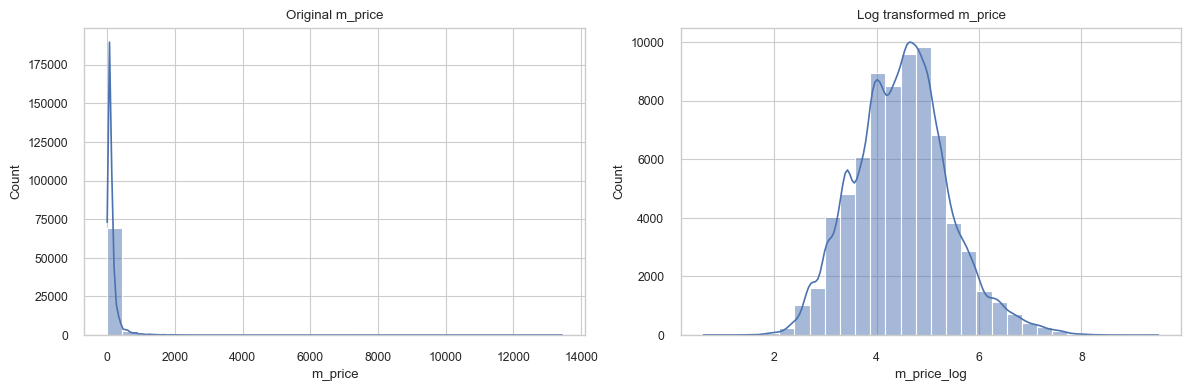

In [49]:
# Log transform total_price
customer_features['m_price_log'] = np.log1p(customer_features['m_price'])

pairs = [('m_price', 'm_price_log')]

for orig, trans in pairs:
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    sns.histplot(customer_features[orig], kde=True, bins=30, ax=axes[0])
    axes[0].set_title(f'Original {orig}')
    sns.histplot(customer_features[trans], kde=True, bins=30, ax=axes[1])
    axes[1].set_title(f'Log transformed {orig}')
    plt.tight_layout()
    plt.savefig(f"./results/log_transformation_{orig}.png")
    plt.show()

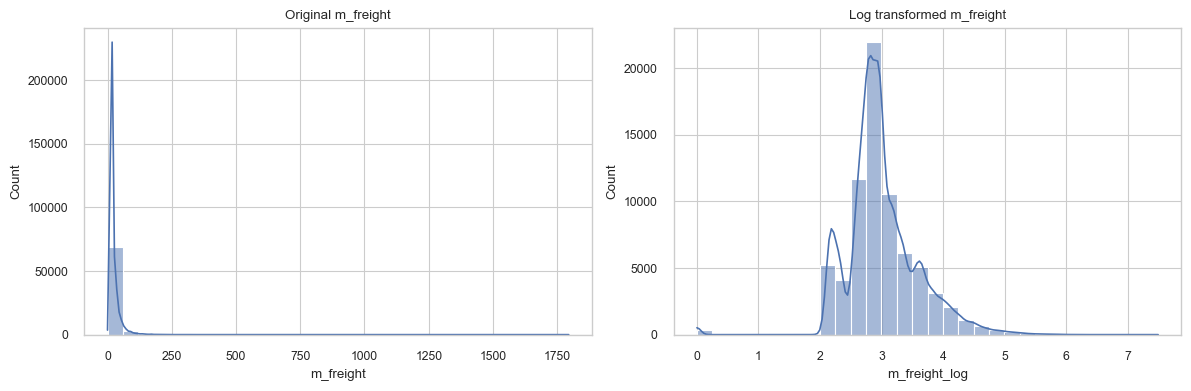

In [51]:
# Log transform total_freight
customer_features['m_freight_log'] = np.log1p(customer_features['m_freight'])

pairs = [('m_freight', 'm_freight_log')]

for orig, trans in pairs:
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    sns.histplot(customer_features[orig], kde=True, bins=30, ax=axes[0])
    axes[0].set_title(f'Original {orig}')
    sns.histplot(customer_features[trans], kde=True, bins=30, ax=axes[1])
    axes[1].set_title(f'Log transformed {orig}')
    plt.tight_layout()
    plt.savefig(f"./results/log_transformation_{orig}.png")
    plt.show()

In [57]:
# m_pct_freight : delivery freight percentage
customer_features['m_pct_freight'] =  customer_features['m_freight'] / customer_features['m_price']

In [59]:
# m_purchasing_power : highlighting major cities SP and RJ
top_cities = {'SP', 'RJ'}
customer_features['m_purchasing_power'] = customer_features['customer_state'].isin(top_cities).astype(int)

In [65]:
# state_spending : average spending of a state
customer_features['state_spending'] = (customer_features.groupby('customer_state')['m_price'].transform('mean'))

In [69]:
# m_value_installments : Purchasing Power
installments = customer_features['m_total_installments'].replace(0, 1)
customer_features['m_value_installments'] = (customer_features['m_price'] + customer_features['m_freight']) / installments

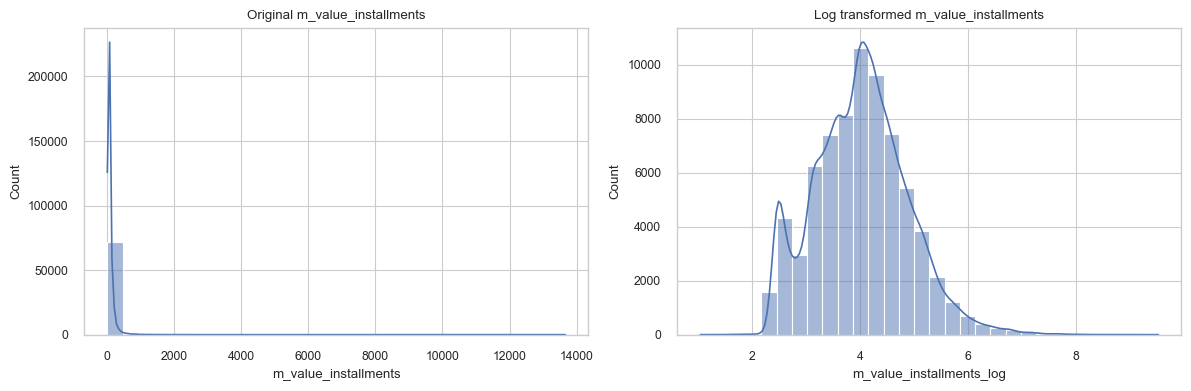

In [71]:
# Log transform total_freight
customer_features['m_value_installments_log'] = np.log1p(customer_features['m_value_installments'])

pairs = [('m_value_installments', 'm_value_installments_log')]

for orig, trans in pairs:
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    sns.histplot(customer_features[orig], kde=True, bins=30, ax=axes[0])
    axes[0].set_title(f'Original {orig}')
    sns.histplot(customer_features[trans], kde=True, bins=30, ax=axes[1])
    axes[1].set_title(f'Log transformed {orig}')
    plt.tight_layout()
    plt.savefig(f"./results/log_transformation_{orig}.png")
    plt.show()

### 5.4 Satisfaction

In [75]:
# delivery_diff_grouped : delivery difference between expected and actual [categorical for visualisation]
conditions = [
    customer_features['s_delivery_diff'] <= -7,
    (customer_features['s_delivery_diff'] > -7) & (customer_features['s_delivery_diff'] < 0),
    customer_features['s_delivery_diff'] == 0,
    (customer_features['s_delivery_diff'] > 0) & (customer_features['s_delivery_diff'] < 7),
    customer_features['s_delivery_diff'] >= 7
]

choices = ['Very early', 'Early', 'On time', 'Late', 'Very late']

customer_features['delivery_diff_grouped'] = np.select(conditions, choices, default='Unknown')

In [79]:
# Replace missing reviews with the average of their delivery_diff_grouped review score
means = customer_features.groupby('delivery_diff_grouped')['s_review_score'].transform('mean')

customer_features['s_review_score'] = customer_features['s_review_score'].fillna(means)

In [81]:
# s_delivery_diff_binary : delivery difference between expected and actual [binary]
customer_features['s_delivery_diff_binary'] = np.where(customer_features['s_delivery_diff'] >= 0, 1, 0)

In [120]:
# s_delivery_diff_binary : low vs high review score
customer_features['s_review_score_cat'] = np.where(customer_features['s_review_score'] < 4, 0, 1)

## 5. Exploratory Data Analysis

In [83]:
# Describe numeric features
features = [
    col for col in customer_features.columns
    if col not in ['geolocation_lat', 'geolocation_lng']
    and customer_features[col].dtype in ('int64','float64')
]

customer_features[features].describe()

,f_orders,f_products,m_price,m_freight,m_credit,m_total_installments,s_review_score,s_delivery_diff,product_score,recency,...,f_basket_size,f_bulk_flag,m_price_log,m_freight_log,m_pct_freight,m_purchasing_power,state_spending,m_value_installments,m_value_installments_log,s_delivery_diff_binary
count,72620.00,72620.00,72620.00,72620.00,72620.00,72620.00,72620.00,72613.00,72619.00,72620.00,...,72620.00,72620.00,72620.00,72620.00,72620.00,72620.00,72620.00,72620.00,72620.00,72620.00
mean,1.03,1.18,141.23,23.70,0.78,2.89,4.13,-10.48,1.48,172.57,...,1.14,0.10,4.49,3.01,0.31,0.55,141.23,84.00,4.03,0.09
std,0.19,0.62,212.20,23.26,0.42,2.67,1.30,9.91,0.32,100.07,...,0.53,0.30,0.92,0.59,0.31,0.50,15.89,138.36,0.86,0.29
min,1.00,1.00,0.85,0.00,0.00,0.00,1.00,-146.02,0.50,0.00,...,1.00,0.00,0.62,0.00,0.00,0.00,128.58,1.86,1.05,0.00
25%,1.00,1.00,47.90,13.88,1.00,1.00,4.00,-15.47,1.24,88.00,...,1.00,0.00,3.89,2.70,0.13,0.00,128.58,29.87,3.43,0.00
50%,1.00,1.00,89.80,17.67,1.00,2.00,5.00,-11.13,1.58,172.00,...,1.00,0.00,4.51,2.93,0.22,1.00,142.96,55.00,4.03,0.00
75%,1.00,1.00,152.00,25.52,1.00,4.00,5.00,-6.11,1.72,260.00,...,1.00,0.00,5.03,3.28,0.38,1.00,145.96,94.78,4.56,0.00
max,11.00,24.00,13440.00,1794.96,1.00,25.00,5.00,188.98,1.96,364.00,...,20.00,1.00,9.51,7.49,21.45,1.00,233.65,13664.08,9.52,1.00


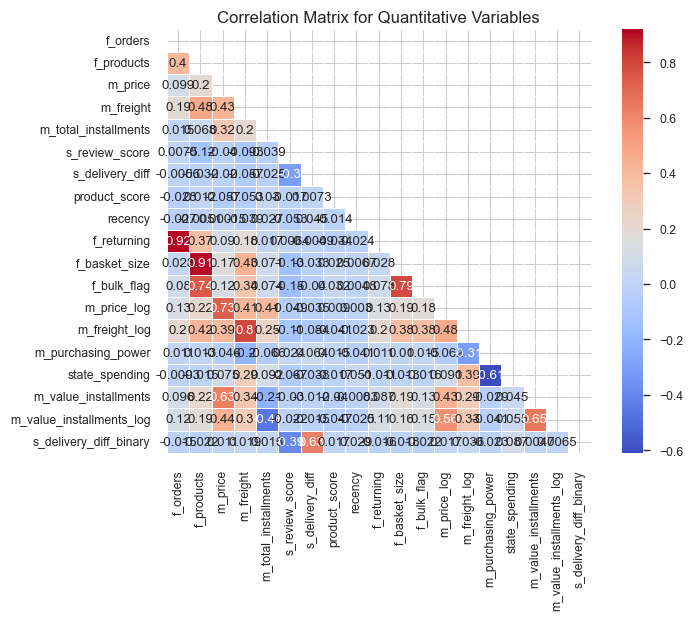

In [85]:
# Correlation matrix
features = [
    col for col in customer_features.columns
    if col not in ['geolocation_lat', 'geolocation_lng', 'm_pct_freight', 'm_credit']
    and customer_features[col].dtype in ('int64','float64')
]

corr = customer_features[features].corr()

# Plot
mask = np.triu(corr)
sns.heatmap(corr, annot=True, cmap='coolwarm', mask=mask, linewidths=.5, cbar=True, square=True)
plt.title("Correlation Matrix for Quantitative Variables", fontsize=12)
plt.savefig(f"./results/Correlation_Matrix_for_Quantitative_Variables.png")
plt.show()

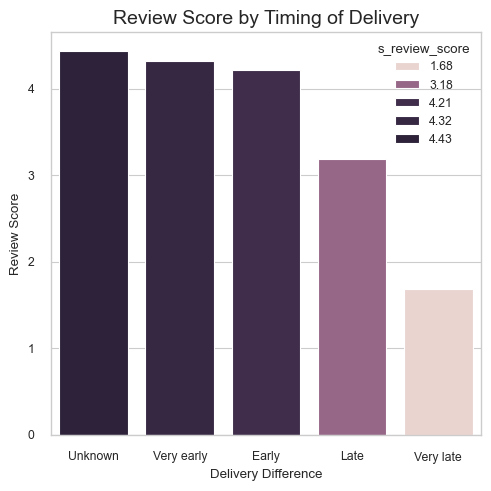

In [87]:
# Review Score by Timing of Delivery
check = customer_features.groupby(['delivery_diff_grouped']).agg({
    's_review_score': 'mean'})

check = check.sort_values('s_review_score', ascending=False).reset_index().round(2)

# Plot
plt.figure(figsize=(5, 5))
sns.barplot(y='s_review_score', x='delivery_diff_grouped', hue='s_review_score', data=check)
plt.title('Review Score by Timing of Delivery', fontsize=14)
plt.xlabel('Delivery Difference')
plt.ylabel('Review Score')
plt.tight_layout()
plt.savefig(f"./results/Review_Score_by_Timing_of_Delivery.png")
plt.show()

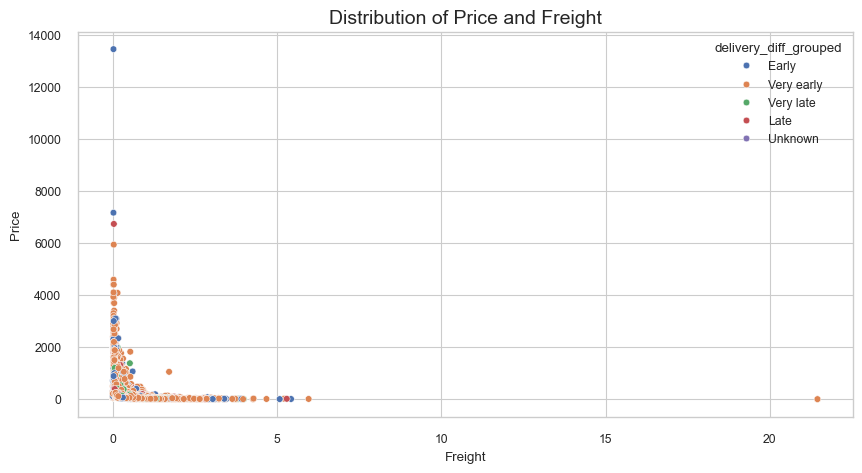

In [89]:
# Distribution of Price and Freight
plt.figure(figsize=(10,5))
sns.scatterplot(data=customer_features, y='m_price', x='m_pct_freight', hue='delivery_diff_grouped')
plt.xlabel("Freight")
plt.ylabel("Price")
plt.title("Distribution of Price and Freight", fontsize=14)
plt.savefig(f"./results/Distribution_of_Price_and_Freight.png")
plt.show()

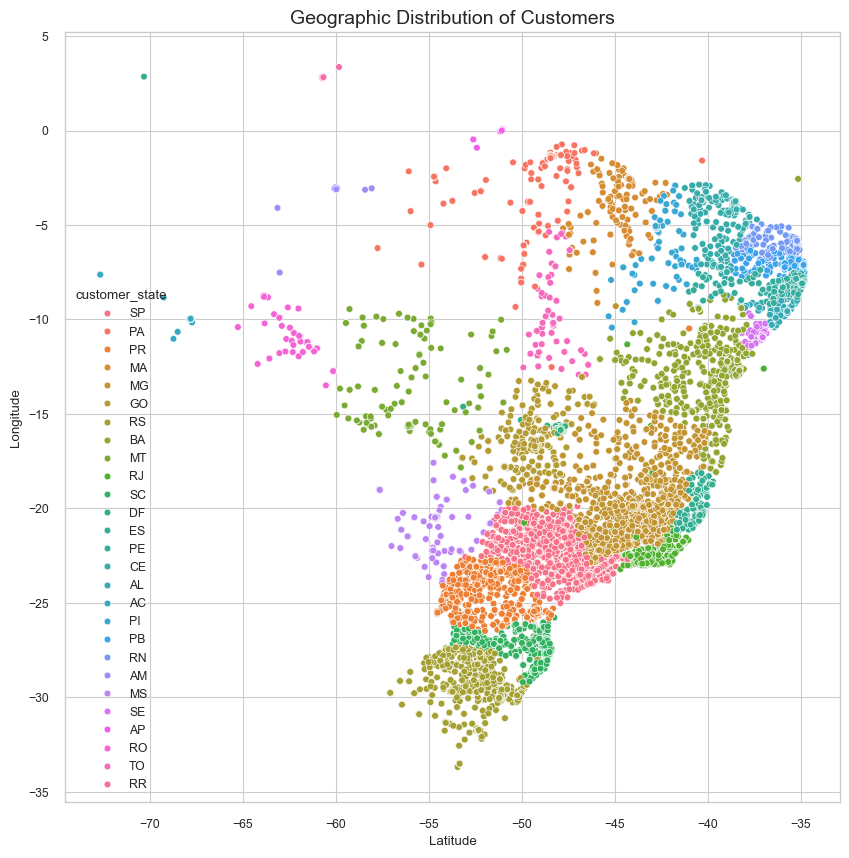

In [91]:
# Geographic spread of customers
plt.figure(figsize=(10,10))
sns.scatterplot(data=customer_features, y='geolocation_lat', x='geolocation_lng', hue='customer_state')
plt.xlabel("Latitude")
plt.ylabel("Longitude")
plt.title("Geographic Distribution of Customers", fontsize=14)
plt.savefig(f"./results/Geographic_Distribution_of_Customers.png")
plt.show()

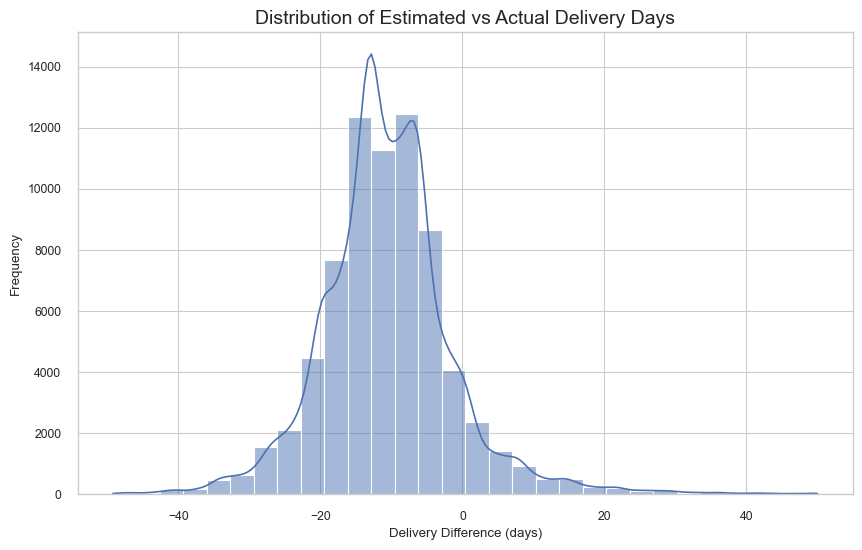

In [93]:
# Distribution of Delivery Difference
df_plot = customer_features[customer_features['s_delivery_diff'].between(-50, 50)]
plt.figure(figsize=(10,6))
sns.histplot(df_plot['s_delivery_diff'], bins=30, kde=True)
plt.xlabel("Delivery Difference (days)")
plt.ylabel("Frequency")
plt.title("Distribution of Estimated vs Actual Delivery Days", fontsize=14)
plt.savefig(f"./results/Distribution_of_Estimated_Actual_Delivery_Days.png")
plt.show()

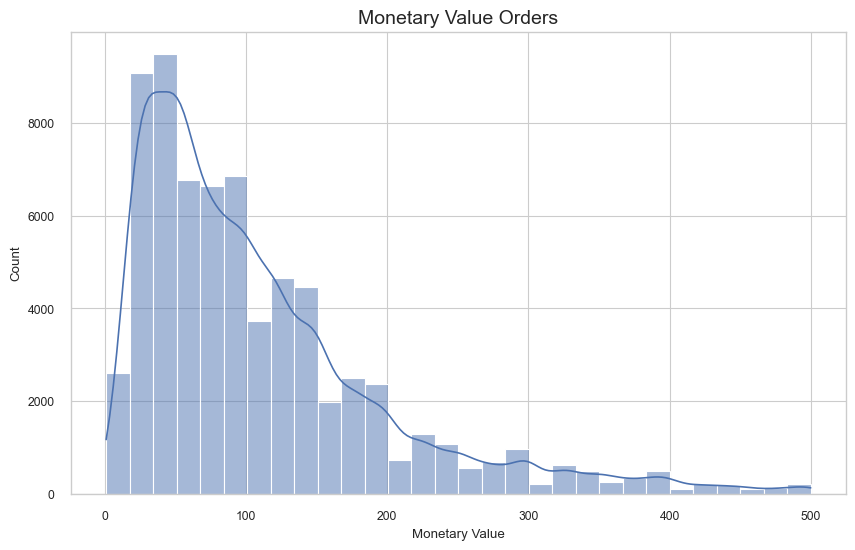

In [95]:
# Distribution of monetary value
df_plot = customer_features[customer_features['m_price'] < 500]
plt.figure(figsize=(10,6))
sns.histplot(df_plot['m_price'], bins=30, kde=True)
plt.xlabel("Monetary Value")
plt.ylabel("Count")
plt.title("Monetary Value Orders", fontsize=14)
plt.savefig(f"./results/Monetary_Value_Orders.png")
plt.show()

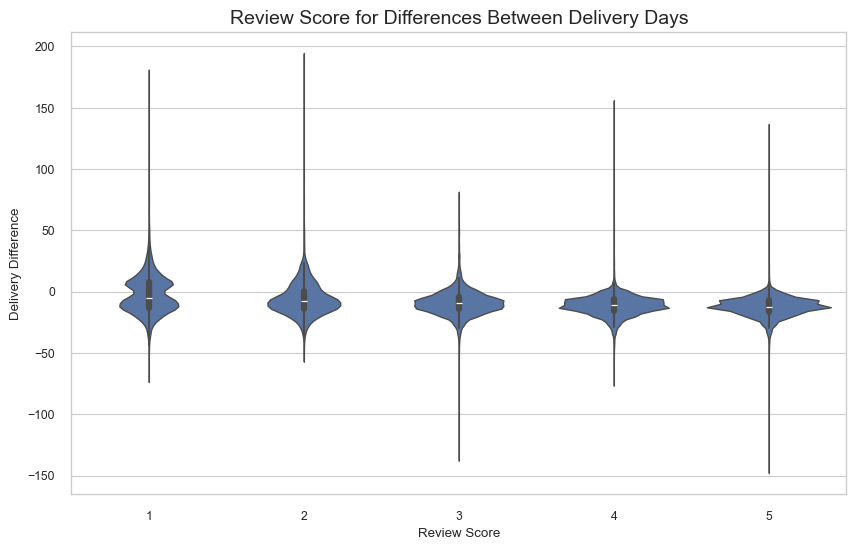

In [97]:
# Review scores against delivery time difference
customer_features['rounded_review_score'] = customer_features['s_review_score'].round(0)

plt.figure(figsize=(10,6))
sns.violinplot(data=customer_features, y='s_delivery_diff', x='rounded_review_score')
plt.xticks(ticks=[0, 1, 2, 3, 4], labels=['1', '2', '3', '4', '5'])
plt.xlabel("Review Score")
plt.ylabel("Delivery Difference")
plt.title("Review Score for Differences Between Delivery Days", fontsize=14)
plt.savefig(f"./results/Review_Score_for_Differences_Between_Delivery_Days.png")
plt.show()

## 7. Export

In [122]:
selected_columns = ['recency',
                    'recent_flag',
                    'f_orders',
                    'f_products',
                    'f_basket_size',
                    'f_bulk_flag',
                    'f_returning',
                    'm_price_log', 
                    'm_pct_freight',
                    'm_purchasing_power',
                    'm_value_installments',
                    'm_total_installments',
                    'm_value_installments_log',
                    'm_credit',
                    's_review_score',
                    's_review_score_cat',
                    's_delivery_diff_binary',
                    's_delivery_diff',
                    'state_spending'
                   ]

df_selected = customer_features[selected_columns]

df_selected = df_selected.dropna()

df_selected.info()

<class 'pandas.core.frame.DataFrame'>
Index: 72613 entries, 0 to 72619
Data columns (total 19 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   recency                   72613 non-null  int64  
 1   recent_flag               72613 non-null  int8   
 2   f_orders                  72613 non-null  int64  
 3   f_products                72613 non-null  int64  
 4   f_basket_size             72613 non-null  float64
 5   f_bulk_flag               72613 non-null  int64  
 6   f_returning               72613 non-null  int64  
 7   m_price_log               72613 non-null  float64
 8   m_pct_freight             72613 non-null  float64
 9   m_purchasing_power        72613 non-null  int64  
 10  m_value_installments      72613 non-null  float64
 11  m_total_installments      72613 non-null  float64
 12  m_value_installments_log  72613 non-null  float64
 13  m_credit                  72613 non-null  float64
 14  s_review_sc

TSNE dimensionality reduction.
apply k means on the 2 dimensiions of the TSNE reducing from the original X (5/6) features.
Non-linear reduction
once you have clusters you go back to the original features 

In [124]:
df_selected.to_csv('./data/processed/processed_database.csv', index=False)

In [134]:
selected_columns = ['order_purchase_timestamp',
                    'recent_flag',
                    'f_returning',
                    'm_price_log',
                    's_delivery_diff_binary'
                   ]

df_maintenance = customer_features[selected_columns]

df_maintenance = df_maintenance.dropna()

df_maintenance.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72620 entries, 0 to 72619
Data columns (total 5 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   order_purchase_timestamp  72620 non-null  datetime64[ns]
 1   recent_flag               72620 non-null  int8          
 2   f_returning               72620 non-null  int64         
 3   m_price_log               72620 non-null  float64       
 4   s_delivery_diff_binary    72620 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(2), int8(1)
memory usage: 2.3 MB


In [136]:
df_maintenance.to_csv('./data/processed/df_maintenance_database.csv', index=False)